# **TRABAJO INTEGRADOR PROCESAMIENTO DEL LENGUAJE NATURAL**

Grupo 1

# **Carga y preparación inicial del dataset para BERT**

Este bloque se encarga de cargar y preparar el dataset para ser utilizado con un modelo basado en BERT. Primero se importan las librerías necesarias para procesamiento de texto, modelado y evaluación. Luego, se carga un archivo CSV que contiene mensajes de soporte, y se combinan las columnas subject y body en una única columna llamada text. A continuación, se codifican las etiquetas de la columna type como valores numéricos en una nueva columna label, lo cual es necesario para el entrenamiento del modelo. Finalmente, se crean dos diccionarios: uno que asigna un número a cada clase (label2id) y otro que hace la conversión inversa (id2label), permitiendo interpretar fácilmente los resultados del modelo.

In [3]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm import tqdm


In [4]:
df = pd.read_csv('dataset_balanceado_7000_por_clase.csv')
df['text'] = df['subject'].fillna('') + ' ' + df['body'].fillna('')
df['label'] = df['type'].astype('category').cat.codes

# Diccionario de clases
label2id = dict(enumerate(df['type'].astype('category').cat.categories))
id2label = {v: k for k, v in label2id.items()}
print("Clases:", label2id)


Clases: {0: 'Change', 1: 'Incident', 2: 'Problem', 3: 'Request'}


# **División del dataset en entrenamiento y prueba con estratificación**

Este bloque divide el dataset en conjuntos de entrenamiento y prueba. Utiliza la función train_test_split para separar los textos (text) y sus respectivas etiquetas (label) en un 80% para entrenamiento y un 20% para prueba. Se aplica la opción stratify para asegurar que ambas particiones mantengan la misma proporción de clases, y se fija una semilla (random_state=42) para garantizar reproducibilidad. Esto es esencial para evaluar el rendimiento del modelo de forma justa y consistente.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)


# **Carga del tokenizer y modelo BERT preentrenado**

En este bloque se carga el tokenizer y el modelo BERT preentrenado (bert-base-uncased) desde la biblioteca transformers. El tokenizer convierte texto en tokens compatibles con BERT, y el modelo genera embeddings a partir de esos tokens. Se llama a model.eval() para poner el modelo en modo evaluación, ya que no se va a entrenar sino solo a usar para extraer representaciones del texto.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval(); 


# **Obtención de embeddings [CLS] con BERT**

Este bloque define una función llamada get_cls_embeddings que recibe una lista de textos y devuelve sus representaciones vectoriales utilizando BERT. Para cada texto, el tokenizer genera los tensores necesarios, y el modelo BERT produce los embeddings. Se extrae el vector correspondiente al token [CLS], que representa el significado global del texto, y se guarda en una lista. Esta función se ejecuta sin calcular gradientes (torch.no_grad()), ya que no se entrena el modelo.

In [7]:
def get_cls_embeddings(texts):
    embeddings = []
    for text in tqdm(texts):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_vector = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_vector)
    return embeddings


# **Entrenamiento del clasificador con embeddings de BERT**

En este bloque se generan los embeddings [CLS] para los conjuntos de entrenamiento y prueba utilizando la función get_cls_embeddings. Luego, se entrena un modelo de regresión logística (LogisticRegression) usando los embeddings como características y las etiquetas reales como objetivo. Finalmente, se generan predicciones (y_pred) sobre el conjunto de prueba. El modelo se entrena con un máximo de 1000 iteraciones para asegurar la convergencia.

In [8]:
X_train_emb = get_cls_embeddings(X_train)
X_test_emb = get_cls_embeddings(X_test)


100%|██████████| 5600/5600 [07:45<00:00, 12.04it/s]


In [9]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_emb, y_train)
y_pred = clf.predict(X_test_emb)


# **Evaluación del modelo: métricas y matriz de confusión**
Este bloque evalúa el rendimiento de nuestro clasificador entrenado. Primero, se imprime un classification_report, que muestra precisión, recall, F1-score y soporte para cada clase. Luego, se calcula y muestra la matriz de confusión con confusion_matrix y ConfusionMatrixDisplay, utilizando las etiquetas correspondientes a cada clase. Esta visualización permite identificar en qué clases el modelo se confunde más, y se presenta en tonos de azul para facilitar su interpretación.

In [10]:
print(classification_report(y_test, y_pred, target_names=[label2id[i] for i in range(len(label2id))]))


              precision    recall  f1-score   support

      Change       0.99      1.00      0.99      1400
    Incident       0.71      0.71      0.71      1400
     Problem       0.71      0.71      0.71      1400
     Request       1.00      0.99      0.99      1400

    accuracy                           0.85      5600
   macro avg       0.85      0.85      0.85      5600
weighted avg       0.85      0.85      0.85      5600



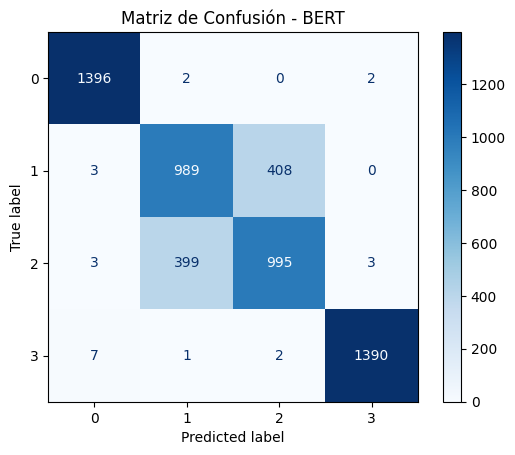

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Etiquetas en orden correcto
target_names = list(label2id.keys())

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - BERT")
plt.show()

# **Guardado del modelo entrenado y datos de prueba**
Este bloque guarda el modelo de regresión logística entrenado (clf) en un archivo .pkl usando la biblioteca joblib, lo que permite reutilizarlo sin necesidad de volver a entrenarlo. Además, también se guardan los embeddings del conjunto de prueba y sus etiquetas reales, lo que facilita realizar evaluaciones posteriores sin tener que volver a generar los vectores con BERT.

In [12]:
import joblib

# Guardar modelo
joblib.dump(clf, 'modelo_regresion_logistica_bert.pkl')

# Guardar embeddings y etiquetas 
joblib.dump((X_test_emb, y_test), 'test_embeddings_y.pkl')


['test_embeddings_y.pkl']

# **Interfaz interactiva para clasificar mensajes usando BERT + Regresión Logística**
Este bloque crea una interfaz interactiva para clasificar mensajes de soporte. Primero, se cargan el modelo entrenado y el tokenizer de BERT. Luego, se define una función que obtiene el embedding [CLS] del texto ingresado y lo pasa al clasificador para predecir su categoría. Finalmente, se construyen elementos de interfaz (Textarea y Button) con ipywidgets, que permiten al usuario ingresar un mensaje y obtener la predicción al hacer clic, mostrando el resultado en consola.

In [13]:
from sklearn.linear_model import LogisticRegression
import ipywidgets as widgets
from IPython.display import display
import numpy as np

#Cargar modelo entrenado
import joblib
clf = joblib.load('modelo_regresion_logistica_bert.pkl')

#Cargar tokenizer y modelo BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

# Diccionario de clases
id2label = {0: "Change", 1: "Incident", 2: "Problem", 3: "Request"}

# Extraemos CLS
def obtener_embedding(texto):
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

# Clasificador
def clasificar(texto):
    emb = obtener_embedding(texto).reshape(1, -1)
    pred = clf.predict(emb)[0]
    print(id2label[pred])

entrada = widgets.Textarea(
    placeholder='Escribí un mensaje de soporte...',
    description='Texto:',
    layout=widgets.Layout(width='100%', height='100px')
)
boton = widgets.Button(description="Clasificar", button_style='success')

def on_click(b):
    clasificar(entrada.value)

boton.on_click(on_click)
display(entrada, boton)

Textarea(value='', description='Texto:', layout=Layout(height='100px', width='100%'), placeholder='Escribí un …

Button(button_style='success', description='Clasificar', style=ButtonStyle())